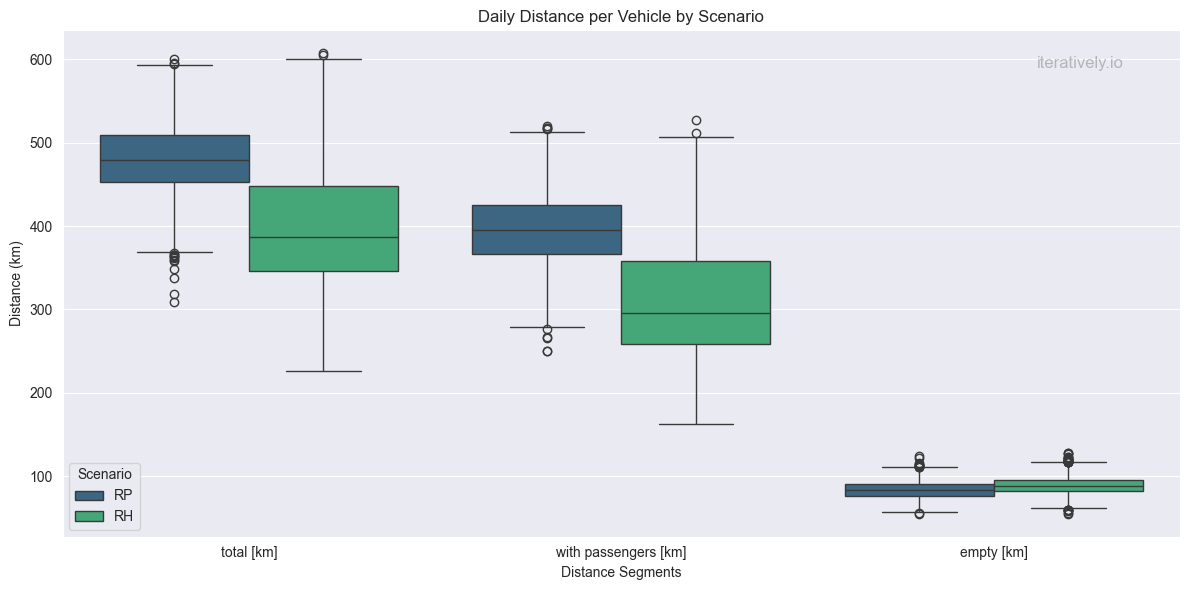

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os


scenarios = {
    "RP": "rp",
    "RH": "rh"
}

basePath = os.path.abspath("C:/Users/steff/IdeaProjects/iteratively-code-examples/outputs")


file_name = "output_vehicleDistanceStats_drt.csv"
all_data = []


for label, uuid in scenarios.items():
    file_path = os.path.join(basePath, uuid, "output","result",file_name)
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    df = pd.read_csv(file_path, sep=';')
    df_km = df[['drivenDistance_m', 'occupiedDistance_m', 'emptyDistance_m']] / 1000 / 7
    df_km.columns = ['total [km]', 'with passengers [km]', 'empty [km]']
    df_km['Scenario'] = label
    all_data.append(df_km)


combined_df = pd.concat(all_data)


df_long = combined_df.melt(id_vars='Scenario', var_name='Distance Segments', value_name='Distance')


plt.figure(figsize=(12, 6))
ax = sns.boxplot(
    data=df_long,
    x='Distance Segments',
    y='Distance',
    hue='Scenario',
    palette='viridis'
)


ax.set_title('Daily Distance per Vehicle by Scenario', fontsize=12)
ax.set_ylabel('Distance (km)', fontsize=10)
ax.tick_params(axis='both', labelsize=10)


ax.text(0.95, 0.95, 'iteratively.io', fontsize=12, color='gray', ha='right', va='top', alpha=0.5, transform=ax.transAxes)


plt.tight_layout()
plt.savefig("daily_distance_comparison.png")
plt.show()


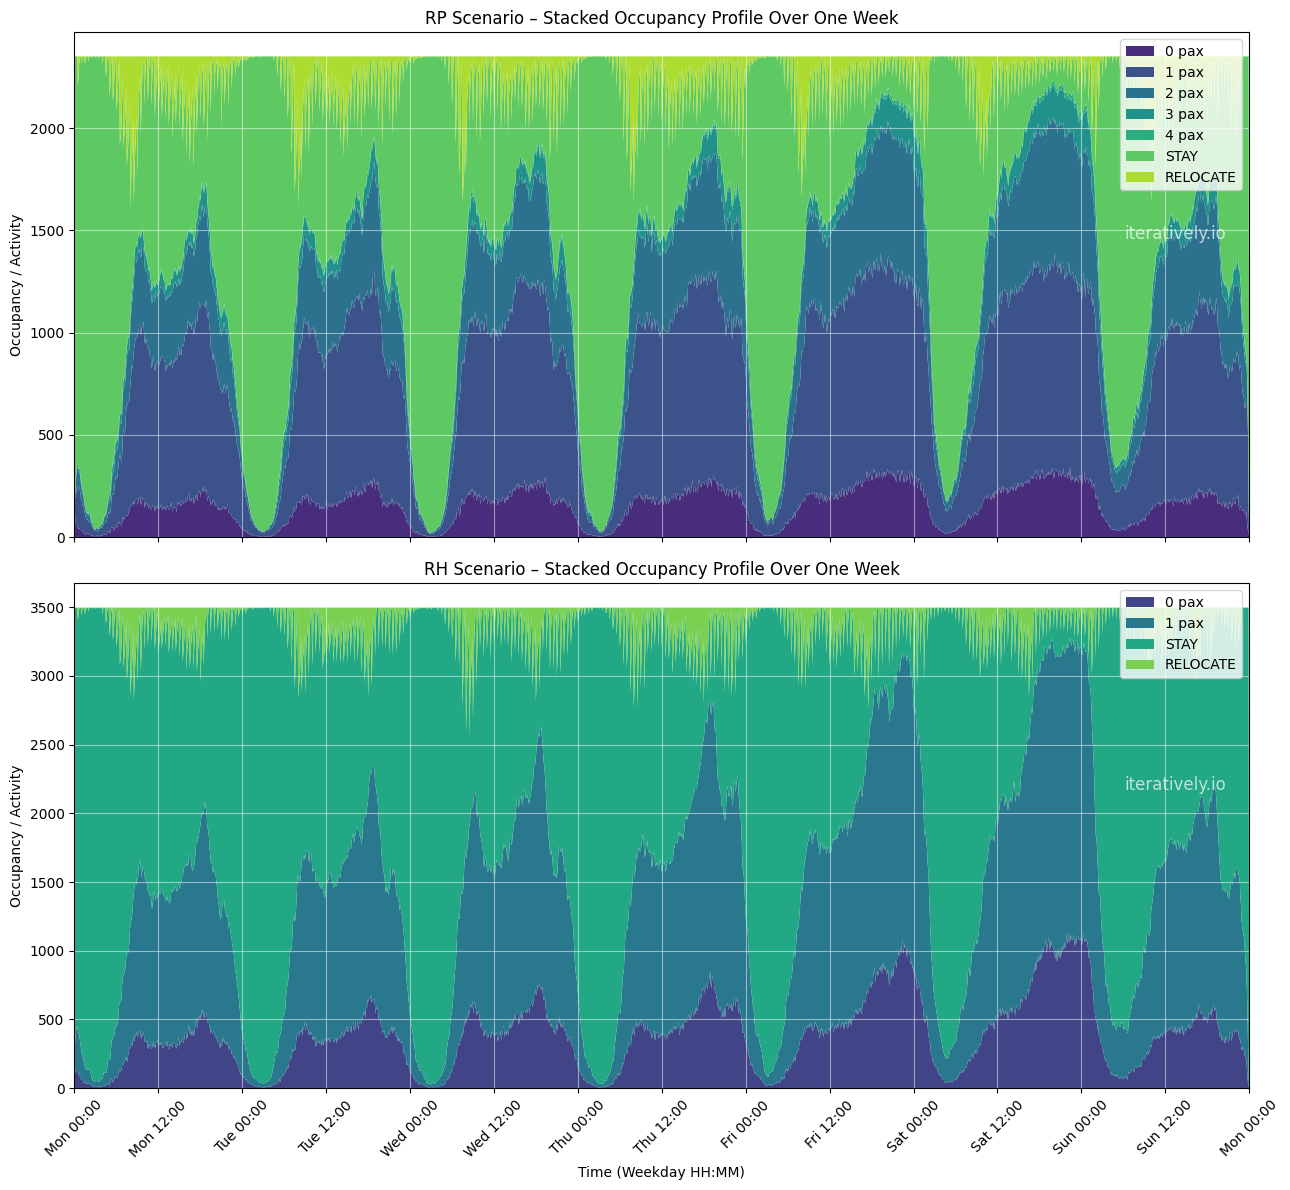

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import os
import locale
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')


scenario_categories = {
    "RP": ['0 pax', '1 pax', '2 pax', '3 pax', '4 pax', 'STAY', 'RELOCATE'],
    "RH": ['0 pax', '1 pax', 'STAY', 'RELOCATE']
}


start = pd.Timestamp('2025-06-02 00:00:00')


fig, axes = plt.subplots(nrows=len(scenarios), ncols=1, figsize=(13, 6 * len(scenarios)), sharex=True)

if len(scenarios) == 1:
    axes = [axes]

for ax, (label, uuid) in zip(axes, scenarios.items()):
    file_path = os.path.join(basePath,uuid,"output","result","ITERS", "it.1", "1.occupancy_time_profiles_drt.txt")
    fleet = pd.read_csv(file_path, sep=';')
    fleet['datetime'] = pd.to_timedelta(fleet['time']) + start

    categories = scenario_categories[label]
    colors = sns.color_palette("viridis", n_colors=len(categories))
    stack_data = [fleet[cat] for cat in categories]

    ax.stackplot(fleet['datetime'], stack_data, labels=categories, colors=colors, linewidth=0.2)
    ax.set_title(f"{label} Scenario – Stacked Occupancy Profile Over One Week")
    ax.set_ylabel('Occupancy / Activity')
    ax.legend(loc='upper right')
    ax.grid(True, color='white',  alpha=0.5)
    ax.text(0.98, 0.60, 'iteratively.io', fontsize=12, color='white', ha='right', va='center', transform=ax.transAxes, alpha=0.7)

    ax.set_xlim([fleet['datetime'].min(), fleet['datetime'].max()])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))


axes[-1].set_xlabel('Time (Weekday HH:MM)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("occupancy_stackplot_faceted.png")
plt.show()


In [1]:
import pandas as pd

# File paths for both scenarios
file1 = "C:/Users/steff/IdeaProjects/iteratively-code-examples/outputs/rh/output/result/volumes.csv"
file2 = "C:/Users/steff/IdeaProjects/iteratively-code-examples/outputs/rp/output/result/volumes.csv"

# Read the files using comma as separator
df1 = pd.read_csv(file1, sep=',')
df2 = pd.read_csv(file2, sep=',')

# Rename volume columns to distinguish them
df1.rename(columns={'volume': 'volume_scenario_1'}, inplace=True)
df2.rename(columns={'volume': 'volume_scenario_2'}, inplace=True)

# Merge the aggregated data on linkId
merged = pd.merge(df1, df2, on='linkId', how='inner')

# Calculate the difference
merged['volume_diff'] = merged['volume_scenario_2'] - merged['volume_scenario_1']
merged['volume_relative_diff_symmetric'] = merged.apply(
    lambda row: row['volume_diff'] / ((row['volume_scenario_1'] + row['volume_scenario_2']) / 2)
    if (row['volume_scenario_1'] + row['volume_scenario_2']) != 0 else 0,
    axis=1
)


# Export to CSV
output_path = "vol_car_comparison_aggregated.csv"
merged.to_csv(output_path, sep=';', index=False)


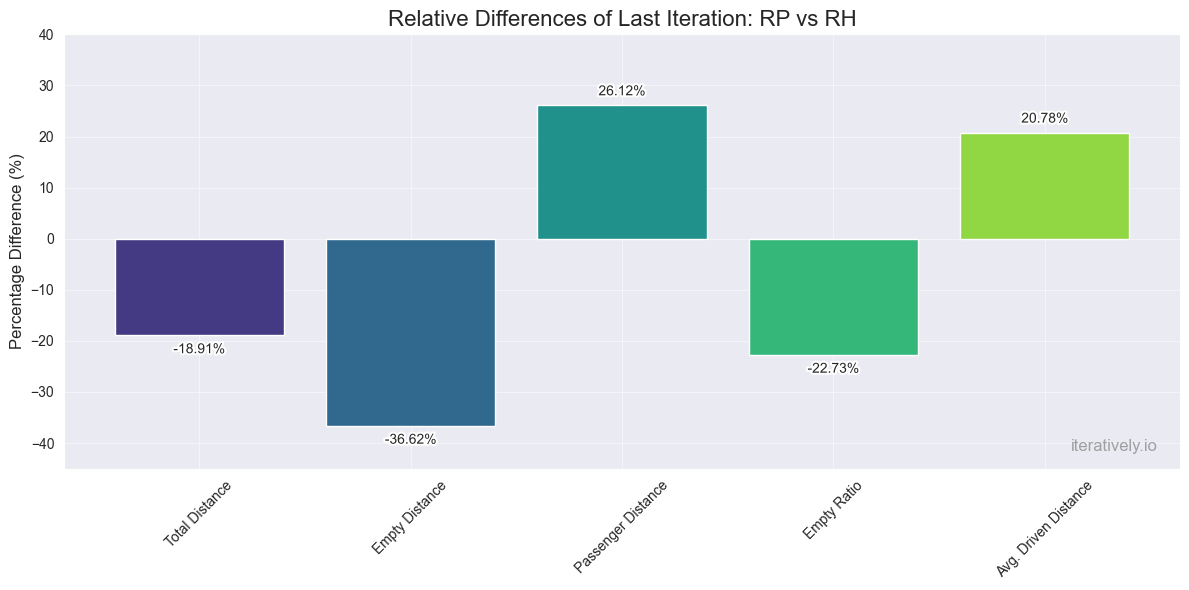

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects

# Load CSV files
rp = pd.read_csv("C:/Users/steff/IdeaProjects/iteratively-code-examples/outputs/rp/output/result/drt_vehicle_stats_drt.csv", sep=';')
rh = pd.read_csv("C:/Users/steff/IdeaProjects/iteratively-code-examples/outputs/rh/output/result/drt_vehicle_stats_drt.csv", sep=';')

# Metrics to compare
metrics = [
    'totalDistance',
    'totalEmptyDistance',
    'totalPassengerDistanceTraveled',
    'emptyRatio',
    'averageDrivenDistance'
]

# Friendly names for metrics
friendly_names = {
    'totalDistance': 'Total Distance',
    'totalEmptyDistance': 'Empty Distance',
    'totalPassengerDistanceTraveled': 'Passenger Distance',
    'emptyRatio': 'Empty Ratio',
    'averageDrivenDistance': 'Avg. Driven Distance'
}

# Extract last iteration (iteration 1)
rp_last = rp[rp['iteration'] == 1][metrics].iloc[0]
rh_last = rh[rh['iteration'] == 1][metrics].iloc[0]

# Calculate percentage difference RP vs RH
relative_diff = ((rp_last - rh_last) / rh_last) * 100

# Plot settings
sns.set_style("darkgrid")
colors = sns.color_palette("viridis", n_colors=len(metrics))

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar([friendly_names[m] for m in metrics], relative_diff, color=colors)

# Title and labels
ax.set_title("Relative Differences of Last Iteration: RP vs RH", fontsize=16)
ax.set_ylabel("Percentage Difference (%)", fontsize=12)
ax.grid(True, color='white', alpha=0.5)

# Add watermark
ax.text(0.98, 0.05, 'iteratively.io', fontsize=12, color='gray', ha='right', va='center', transform=ax.transAxes, alpha=0.7)

# Annotate bars with white text buffer
for bar in bars:
    height = bar.get_height()
    if height >= 0:
        va = 'bottom'
        y_offset = 5
    else:
        va = 'top'
        y_offset = -5
    text = ax.annotate(f'{height:.2f}%',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, y_offset),
                       textcoords="offset points",
                       ha='center', va=va, fontsize=10)
    text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'), path_effects.Normal()])

ax.set_ylim([-45, 40])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("relative_comparison_rp_vs_rh.png")
plt.show()

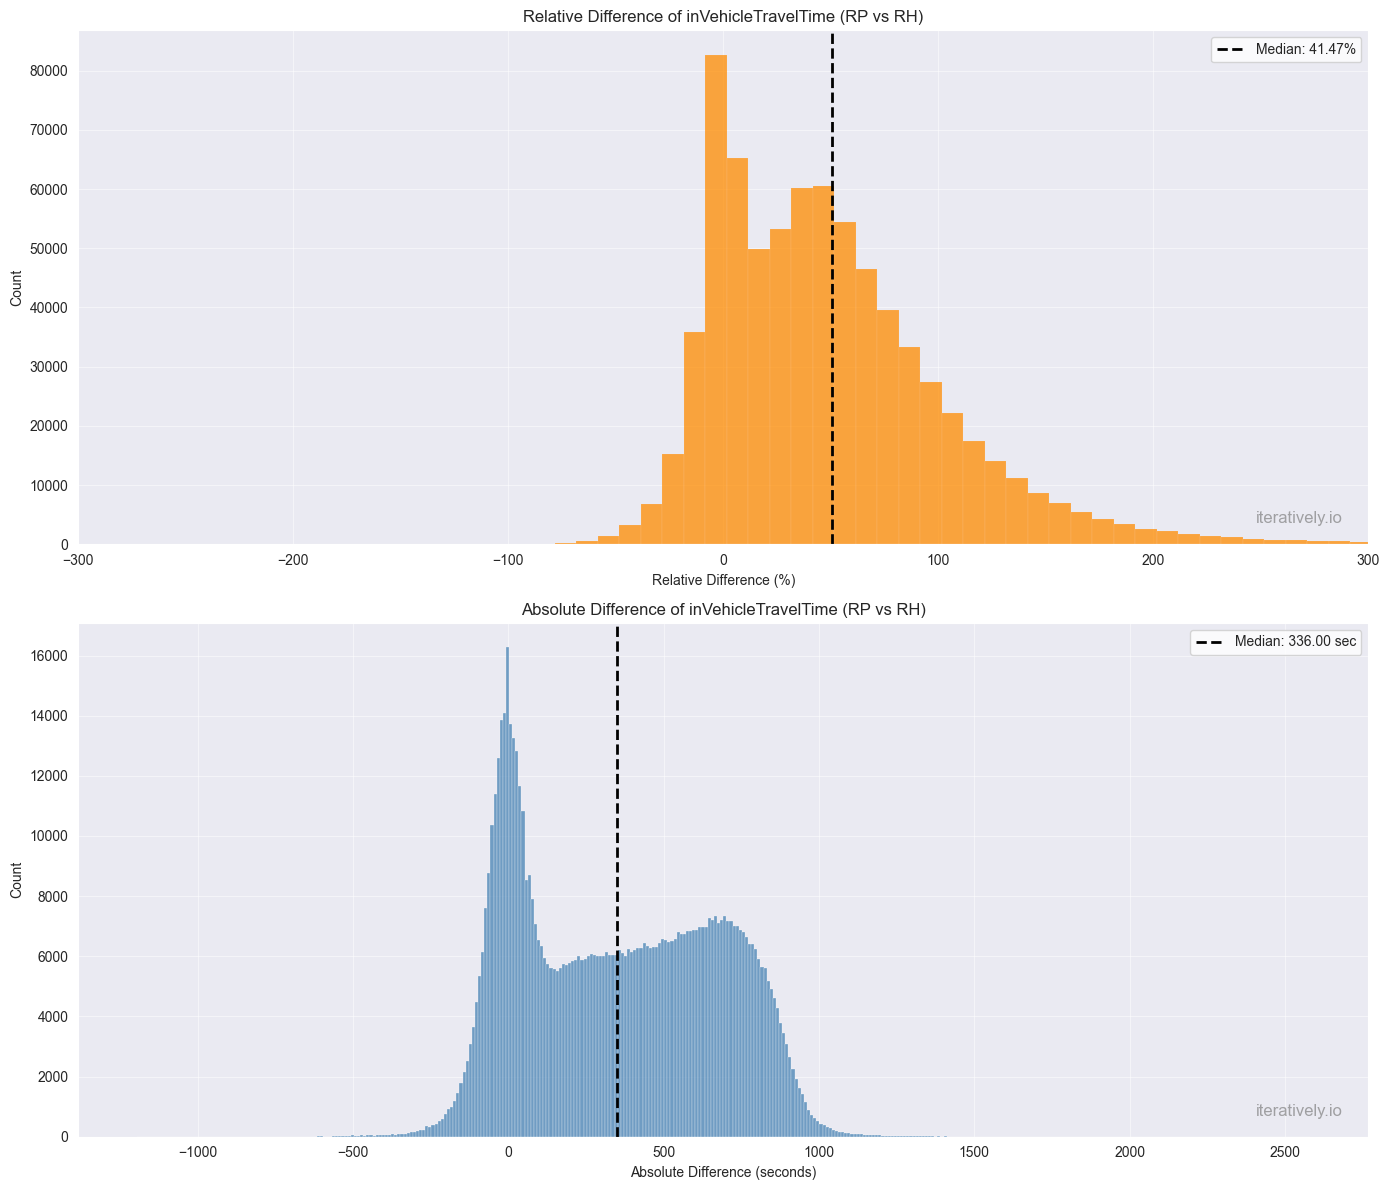

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Lade die beiden Dateien
rp = pd.read_csv("C:/Users/steff/IdeaProjects/iteratively-code-examples/outputs/rp/output/result/output_drt_legs_drt.csv", sep=';')
rh = pd.read_csv("C:/Users/steff/IdeaProjects/iteratively-code-examples/outputs/rh/output/result/output_drt_legs_drt.csv", sep=';')

# Merge on personId
merged = pd.merge(rp[['personId', 'inVehicleTravelTime']],
                  rh[['personId', 'inVehicleTravelTime']],
                  on='personId',
                  suffixes=('_rp', '_rh'))

# Berechne relative Differenz
merged['rel_diff'] = ((merged['inVehicleTravelTime_rp'] - merged['inVehicleTravelTime_rh']) / merged['inVehicleTravelTime_rh']) * 100
median_rel_diff = merged['rel_diff'].median()
# Berechne absolute Differenz
merged['abs_diff'] = merged['inVehicleTravelTime_rp'] - merged['inVehicleTravelTime_rh']
median_abs_diff = merged['abs_diff'].median()

# Erstelle neuen Plot mit zwei Subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 12))
sns.set_style("whitegrid")

# Plot 1: Relative Differenz
sns.histplot(merged['rel_diff'], binwidth=10, color='darkorange', ax=axes[0])
axes[0].set_title("Relative Difference of inVehicleTravelTime (RP vs RH)")
axes[0].set_ylabel("Count")
axes[0].set_xlim([-300, 300])
axes[0].set_xlabel("Relative Difference (%)")
axes[0].grid(True, color='white', alpha=0.5)
axes[0].axvline(median_rel_diff, color='black', linestyle='--', linewidth=2, label=f'Median: {median_rel_diff:.2f}%')
axes[0].legend()
axes[0].text(0.98, 0.05, 'iteratively.io', fontsize=12, color='gray',
             ha='right', va='center', transform=axes[0].transAxes, alpha=0.7)

# Plot 2: Absolute Differenz
sns.histplot(merged['abs_diff'], binwidth=10, color='steelblue', ax=axes[1])
axes[1].set_title("Absolute Difference of inVehicleTravelTime (RP vs RH)")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Absolute Difference (seconds)")
axes[1].grid(True, color='white', alpha=0.5)
axes[1].axvline(median_abs_diff, color='black', linestyle='--', linewidth=2, label=f'Median: {median_abs_diff:.2f} sec')
axes[1].legend()
axes[1].text(0.98, 0.05, 'iteratively.io', fontsize=12, color='gray',
             ha='right', va='center', transform=axes[1].transAxes, alpha=0.7)

plt.tight_layout()
plt.savefig("inVehicleTravelTime_comparison.png")
plt.show()